In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:

new_17 = pd.DataFrame()
new_17['pitcher_id'] = [i for i in pitcherid]
new_17

,pitcher_id
0,466948
1,456713
2,622608
3,501789
4,596001
...,...
750,489446
751,628711
752,475115
753,456696


In [2]:
pitches = pd.read_csv("/Users/bradyhong/Downloads/archive/pitches.csv")

In [3]:
atbats = pd.read_csv('/Users/bradyhong/Downloads/archive/atbats.csv')

In [4]:
games = pd.read_csv('games.csv') 

In [5]:
names = pd.read_csv('/Users/bradyhong/Downloads/archive/player_names.csv')

In [6]:
# Merging pitches and atbats by ab_id
data = pd.merge(pitches, atbats, on = 'ab_id', how = 'left')

In [7]:
# Merging games data with pitches and atbats by g_id
data = pd.merge(data, games, on = 'g_id', how = 'left')

In [8]:
data1 = data.g_id.astype('str')

In [9]:
#Since the year is the first four characters, we will isolate those characters
data1 = data1.str[:4]

In [10]:
data['year'] = data1.values

In [11]:
data17 = data[data['year'] == '2017']

In [12]:
data17 = pd.merge(data17, names, left_on = 'pitcher_id', right_on = 'id')

In [13]:
data17.to_csv("data17.csv")

In [63]:
pd.read_csv("data17.csv")

,Unnamed: 0,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,...,wind,delay,temperature,condition,speed,direction,year,id,first_name,last_name
0,0,0.281634,4.334447,94.9,86.1,1815.174,219.013,27.1,4.4,23.8,...,"8 mph, R to L",0,63,cloudy,8 mph,R to L,2017,593372,Carlos,Martinez
1,1,-0.578784,2.324124,95.9,87.7,2510.709,241.800,42.7,6.1,23.8,...,"8 mph, R to L",0,63,cloudy,8 mph,R to L,2017,593372,Carlos,Martinez
2,2,-0.014284,1.326134,97.3,89.0,2116.491,246.445,34.9,6.1,23.8,...,"8 mph, R to L",0,63,cloudy,8 mph,R to L,2017,593372,Carlos,Martinez
3,3,0.135816,1.943402,84.6,77.9,1235.405,81.065,-17.2,9.4,23.8,...,"8 mph, R to L",0,63,cloudy,8 mph,R to L,2017,593372,Carlos,Martinez
4,4,0.421448,1.833604,98.4,89.5,2140.052,242.020,35.9,5.7,23.8,...,"8 mph, R to L",0,63,cloudy,8 mph,R to L,2017,593372,Carlos,Martinez
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724613,724613,0.058399,1.255531,96.5,88.3,3164.095,234.943,54.2,5.8,23.8,...,"11 mph, In from RF",0,65,sunny,11 mph,In from RF,2017,622492,Keury,Mella
724614,724614,1.048686,2.899254,95.8,87.6,2406.047,223.469,39.8,4.4,23.8,...,"11 mph, In from RF",0,65,sunny,11 mph,In from RF,2017,622492,Keury,Mella
724615,724615,-0.760725,2.308901,82.4,75.9,660.491,141.294,-7.6,7.9,23.9,...,"11 mph, In from RF",0,65,sunny,11 mph,In from RF,2017,622492,Keury,Mella
724616,724616,-0.718452,1.313040,98.1,90.7,2548.311,205.286,39.8,3.0,23.8,...,"11 mph, In from RF",0,65,sunny,11 mph,In from RF,2017,622492,Keury,Mella


In [64]:
data17_merge = pd.DataFrame(data17[['pitch_type', 'pitcher_id']])

In [17]:
data17_merge = data17_merge[data17_merge.pitch_type != 'AB']
data17_merge = data17_merge[data17_merge.pitch_type != 'UN']
data17_merge = data17_merge[data17_merge.pitch_type != 'EP']
data17_merge = data17_merge[data17_merge.pitch_type != 'SC']
data17_merge = data17_merge[data17_merge.pitch_type != 'PO']
data17_merge = data17_merge[data17_merge.pitch_type != 'FO']

In [19]:
data17_merge.dropna()

,pitch_type,pitcher_id
0,FF,593372
1,FT,593372
2,FT,593372
3,SL,593372
4,FT,593372
...,...,...
724613,FT,622492
724614,FF,622492
724615,SL,622492
724616,FF,622492


In [65]:
pitcherid=set()
for i in data17_merge.pitcher_id:
    pitcherid.add(i)

In [66]:
pitcherid

{112526,
 276351,
 276520,
 276542,
 279571,
 282332,
 285079,
 407793,
 407822,
 407845,
 408061,
 424144,
 425386,
 425492,
 425794,
 425844,
 429719,
 429722,
 430589,
 430599,
 430641,
 430661,
 430912,
 430935,
 430947,
 432934,
 433217,
 433586,
 433587,
 433589,
 434378,
 434442,
 434538,
 434563,
 434622,
 434628,
 434671,
 434672,
 434718,
 435043,
 435221,
 435400,
 444468,
 444520,
 444857,
 445055,
 445060,
 445197,
 445213,
 445276,
 445926,
 446099,
 446372,
 446399,
 446899,
 447714,
 448179,
 448281,
 448306,
 448609,
 448614,
 448802,
 448855,
 449173,
 450172,
 450203,
 450212,
 450282,
 450306,
 450308,
 450729,
 451584,
 451596,
 451661,
 452027,
 452657,
 452666,
 452718,
 453172,
 453178,
 453192,
 453214,
 453265,
 453281,
 453284,
 453286,
 453329,
 453343,
 453344,
 453385,
 453562,
 455009,
 455374,
 455376,
 456034,
 456068,
 456167,
 456379,
 456501,
 456696,
 456701,
 456713,
 457117,
 457429,
 457732,
 457768,
 457915,
 457918,
 458006,
 458584,
 458676,
 

In [85]:
FF = 0
SL = 0
FT = 0
CH = 0
CU = 0
SI = 0
FC = 0
KC = 0
FS = 0
KN = 0
index = data17_merge.index
tempid = ""
count = 0
new_17['FF'] = np.nan
new_17['SL'] = np.nan
new_17['FT'] = np.nan
new_17['CH'] = np.nan
new_17['CU'] = np.nan
new_17['SI'] = np.nan
new_17['FC'] = np.nan
new_17['KC'] = np.nan
new_17['FS'] = np.nan
new_17['KN'] = np.nan
for j in pitcherid:
    for i in index:
        if data17_merge.loc[index[i], "pitcher_id"] == j:     
            if data17_merge.loc[index[i], "pitch_type"] == "FF":
                FF += 1
            elif data17_merge.loc[index[i], "pitch_type"] == "SL":
                SL += 1
            elif data17_merge.loc[index[i], "pitch_type"] == "FT":
                FT += 1
            elif data17_merge.loc[index[i], "pitch_type"] == "CH":
                CH += 1
            elif data17_merge.loc[index[i], "pitch_type"] == "CU":
                CU += 1
            elif data17_merge.loc[index[i], "pitch_type"] == "SI":
                SI += 1
            elif data17_merge.loc[index[i], "pitch_type"] == "FC":
                FC += 1
            elif data17_merge.loc[index[i], "pitch_type"] == "KC":
                KC += 1
            elif data17_merge.loc[index[i], "pitch_type"] == "FS":
                FS += 1
            elif data17_merge.loc[index[i], "pitch_type"] == "KN":
                KN += 1
    total = FF+SL+FT+CH+CU+SI+KC+FS+KN+FC
    new_17.loc[count, "FF"] = FF/total
    new_17.loc[count, "SL"] = SL/total
    new_17.loc[count, "FT"] = FT/total
    new_17.loc[count, "CH"] = CH/total
    new_17.loc[count, "CU"] = CU/total
    new_17.loc[count, "SI"] = SI/total
    new_17.loc[count, "FC"] = FC/total
    new_17.loc[count, "KC"] = KC/total
    new_17.loc[count, "FS"] = FS/total
    new_17.loc[count, "KN"] = KN/total
    FF = 0
    SL = 0
    FT = 0
    CH = 0
    CU = 0
    SI = 0
    FC = 0
    KC = 0
    FS = 0
    KN = 0
    count+=1


0
0.4766355140186916
0.009345794392523364
0.056074766355140186
1
0.451271186440678
0.04766949152542373
0.24046610169491525
2
0.7204155374887082
0.22177055103884372
0.0
3
0.2653673163418291
0.0
0.0
4
0.20973044049967127
0.33925049309664695
0.0
5
0.3336510962821735
0.46234509056244044
0.1754051477597712
6
0.5516260162601626
0.08983739837398375
0.1048780487804878
7
0.23539668700959024
0.2074978204010462
0.0
8
0.64
0.0
0.32
9
0.38060179257362353
0.0
0.0
10
0.4936708860759494
0.0
0.004219409282700422
11
0.5210420841683366
0.35771543086172347
0.09318637274549098
12
0.4876604146100691
0.2694965449160908
0.045409674234945706
13
0.24444444444444444
0.0
0.0
14
0.34811529933481156
0.21951219512195122
0.22172949002217296
15
0.3669724770642202
0.5229357798165137
0.06422018348623854
16
0.5017421602787456
0.1254355400696864
0.09291521486643438
17
0.49355797819623387
0.24578790882061446
0.0009910802775024777
18
0.19881889763779528
0.2854330708661417
0.3572834645669291
19
0.5454545454545454
0.0
0.0
20


163
0.5138490926456543
0.0
0.0
164
0.6302186878727635
0.0
0.073558648111332
165
0.1729883020205601
0.0
0.0
166
0.30670926517571884
0.4472843450479233
0.22364217252396165
167
0.035414165666266505
0.05582232893157263
0.0
168
0.02194787379972565
0.4869684499314129
0.0
169
0.516514406184118
0.0
0.0
170
0.5645161290322581
0.3467741935483871
0.03225806451612903
171
0.43037974683544306
0.21518987341772153
0.10126582278481013
172
0.5181818181818182
0.4727272727272727
0.0
173
0.5522388059701493
0.0
0.09629272989889263
174
0.3648960739030023
0.13163972286374134
0.19630484988452657
175
0.35116804822908815
0.28711379050489827
0.07234363225320271
176
0.43715341959334564
0.09611829944547134
0.10351201478743069
177
0.0196078431372549
0.0
0.0
178
0.5530474040632054
0.0
0.0056433408577878106
179
0.5609756097560976
0.024390243902439025
0.024390243902439025
180
0.18663806313208703
0.18786392889978548
0.3089181734600061
181
0.03158281307381564
0.1395519647447668
0.0
182
0.0
0.0
0.0
183
0.3875432525951557


324
0.13346613545816732
0.0
0.0
325
0.5946398659966499
0.12060301507537688
0.0
326
0.4934210526315789
0.26973684210526316
0.05131578947368421
327
0.6829268292682927
0.0
0.002613240418118467
328
0.5543766578249337
0.0
0.005305039787798408
329
0.3060007454342154
0.20573984345881477
0.0
330
0.36853448275862066
0.0
0.22772988505747127
331
0.5138121546961326
0.0
0.0
332
0.7237715803452855
0.18592297476759628
0.0
333
0.46833013435700577
0.1036468330134357
0.16506717850287908
334
0.5888077858880778
0.18491484184914841
0.0
335
0.2982456140350877
0.189792663476874
0.24561403508771928
336
0.39668769716088326
0.22476340694006308
0.0
337
0.35195530726256985
0.1005586592178771
0.22346368715083798
338
0.508577194752775
0.06861755802219979
0.0
339
0.7997432605905006
0.11296534017971759
0.011553273427471117
340
0.2765273311897106
0.4790996784565916
0.0
341
0.3301260783012608
0.20305242203052423
0.35733244857332447
342
0.5113895216400911
0.4157175398633257
0.00683371298405467
343
0.3821892393320965
0.5

483
0.5909090909090909
0.0
0.0
484
0.36133452487339884
0.0
0.20464700625558535
485
0.611336032388664
0.23157894736842105
0.009716599190283401
486
0.032467532467532464
0.20454545454545456
0.0
487
0.32083792723263505
0.0
0.15214994487320838
488
0.3381128584643848
0.22571692876965774
0.1341350601295097
489
0.4
0.20330578512396694
0.03471074380165289
490
0.31625054752518617
0.21550591327201052
0.19229084537888744
491
0.641444539982803
0.22012037833190026
0.0997420464316423
492
0.0
0.0
0.5777994791666666
493
0.4599786552828175
0.3265741728922092
0.09391675560298826
494
0.30303030303030304
0.0
0.6363636363636364
495
0.28918169209431344
0.014563106796116505
0.0
496
0.00995850622406639
0.11867219917012448
0.0
497
0.44871794871794873
0.4807692307692308
0.0
498
0.38127090301003347
0.0
0.18171683389074694
499
0.5580524344569289
0.2397003745318352
0.04119850187265917
500
0.700354609929078
0.0
0.0008865248226950354
501
0.6088235294117647
0.0
0.01764705882352941
502
0.2108695652173913
0.0
0.0
503
0.

650
0.4482758620689655
0.0
0.0
651
0.32028112449799195
0.23694779116465864
0.3102409638554217
652
0.38343296327924853
0.35098206660973524
0.0
653
0.054337899543379
0.18812785388127853
0.5287671232876713
654
0.0750256937307297
0.0
0.6073997944501541
655
0.7027027027027027
0.2972972972972973
0.0
656
0.0
0.0
0.0
657
0.13445378151260504
0.5630252100840336
0.0
658
0.13500404203718674
0.0
0.423605497170574
659
0.11148648648648649
0.3885135135135135
0.0
660
0.4774011299435028
0.24858757062146894
0.1497175141242938
661
0.07142857142857142
0.19047619047619047
0.0
662
0.3425287356321839
0.2450574712643678
0.08597701149425287
663
0.4855769230769231
0.0
0.0
664
0.6300148588410104
0.02526002971768202
0.020802377414561663
665
0.2940563086548488
0.24504692387904067
0.1553701772679875
666
0.33954451345755693
0.0
0.0
667
0.5393765381460214
0.1505332239540607
0.1214109926168991
668
0.3430232558139535
0.25872093023255816
0.0377906976744186
669
0.14606741573033707
0.0
0.0
670
0.4792626728110599
0.28940092

In [87]:
new_17.to_csv("new_17.csv")

In [ ]:
new_17 = pd.read_csv("new_17.csv")

In [11]:
# Using only 2018 year
data18 = data[data['year'] == '2018']

In [12]:
# Merging the data with names
data18 = pd.merge(data18, names, left_on = 'pitcher_id', right_on = 'id')

In [13]:
# Making speed as numeric
data18['speed'] = data18['speed'].str[:-3]
data18['speed'] = data18.speed.astype('int')

In [14]:
# Changing to numeric
from sklearn.preprocessing import LabelEncoder
number = LabelEncoder()
data18['venue_name'] = number.fit_transform(data18['venue_name'])
data18['condition'] = number.fit_transform(data18['condition'])

In [15]:
def new_column(row):
    if row['direction'][:1] == 'O':
        return 1
    elif row['direction'][:1] == 'I':
        return 2
    else:
        return 0

In [16]:
# Changind dirction value to 0,1,2
data18['direction'] = data18.apply(new_column, axis=1)

In [17]:
new_data = pd.DataFrame(data18[['pitch_type', 'b_score', 's_count', 'outs', 'pitch_num', \
                            'on_1b', 'on_2b', 'on_3b', 'batter_id', 'inning', 'p_score', 'p_throws',\
                             'pitcher_id', 'stand', 'top', 'b_count',\
                          'venue_name','speed', 'direction',\
                          'temperature', 'condition']])

In [2]:
pXs = new_data.to_csv("pXs.csv")

NameError: name 'new_data' is not defined

Now we can get more specific with our scrubbing to further clean our dataset. We will create a new DataFrame called pXs (pitch X situation) and reduce our columns to game situational data. As much of the pitches file is individual statistics on the pitch thrown, it would defeat the purpose of attempting to predict a pitch if the data of the pitch was provided.

In [160]:
pXs = pd.read_csv("pXs.csv", index_col=[0])

In [161]:
pXs = pd.merge(pXs, new_17, on = 'pitcher_id')

In [162]:
pXs.isnull().sum()

pitch_type     4990
b_score           0
s_count           0
outs              0
pitch_num         0
on_1b             0
on_2b             0
on_3b             0
batter_id         0
inning            0
p_score           0
p_throws          0
pitcher_id        0
stand             0
top               0
b_count           0
venue_name        0
speed             0
direction         0
temperature       0
condition         0
FF                0
SL                0
FT                0
CH                0
CU                0
SI                0
FC                0
KC                0
FS                0
KN                0
dtype: int64

In [163]:
# Drop that has null pitch_type
pXs = pXs.dropna()

In [164]:
# Changing values to numeric
pXs.p_throws = pXs.p_throws.replace(['R', 'L'], [0,1])
pXs.stand = pXs.stand.replace(['R', 'L'], [0,1])
pXs.top = pXs.top.replace([True, False], [1,0])

In [165]:
pXs.pitch_type.value_counts()

FF    209662
SL    104247
FT     74277
CH     64540
CU     50112
SI     48013
FC     34329
KC     15992
FS      8985
KN       719
EP       203
FO        84
PO        77
SC        37
AB         1
Name: pitch_type, dtype: int64

In [166]:
# Deleting pitch types that have low value counts
pXs = pXs[pXs.pitch_type != 'AB']
pXs = pXs[pXs.pitch_type != 'UN']
pXs = pXs[pXs.pitch_type != 'EP']
pXs = pXs[pXs.pitch_type != 'SC']
pXs = pXs[pXs.pitch_type != 'PO']
pXs = pXs[pXs.pitch_type != 'FO']

In [140]:
# Recency Feature
from sklearn.preprocessing import LabelEncoder
def recency(depth):
    number = LabelEncoder()
    for a in range(depth):
        pXs["t-"+str(a+1)+" pitch_type"] = np.nan
    index = pXs.index 
    print(index)
    for j in range(len(index)-depth):
        if pXs.loc[index[j+depth], "pitcher_id"] == pXs.loc[index[j], "pitcher_id"]:
            for c in range(depth):
                past = pXs.loc[index[j+depth-c-1]]
                pXs.loc[index[j+depth], "t-"+str(c+1)+" pitch_type"] = past.pitch_type
    for d in range(depth):
        pXs['t-'+str(d+1)+' pitch_type'] = pXs['t-'+str(d+1)+' pitch_type'].astype('str')             
        pXs['t-'+str(d+1)+' pitch_type'] = number.fit_transform(pXs['t-'+str(d+1)+' pitch_type'])
recency(3)

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            202013, 202014, 202015, 202016, 202017, 202018, 202019, 202020,
            202021, 202022],
           dtype='int64', length=200000)


KeyboardInterrupt: 

In [ ]:
pXs.to_csv("recency_feature.csv")

In [167]:
pXs.head(20)

,pitch_type,b_score,s_count,outs,pitch_num,on_1b,on_2b,on_3b,batter_id,inning,...,FF,SL,FT,CH,CU,SI,FC,KC,FS,KN
0,SI,0.0,0.0,0.0,1.0,0.0,0.0,0.0,446359,1,...,0.035414,0.055822,0.0,0.106843,0.0,0.663866,0.138055,0.0,0.0,0.0
1,SI,0.0,1.0,0.0,2.0,0.0,0.0,0.0,446359,1,...,0.035414,0.055822,0.0,0.106843,0.0,0.663866,0.138055,0.0,0.0,0.0
2,SI,0.0,1.0,0.0,3.0,0.0,0.0,0.0,446359,1,...,0.035414,0.055822,0.0,0.106843,0.0,0.663866,0.138055,0.0,0.0,0.0
3,SL,0.0,2.0,0.0,4.0,0.0,0.0,0.0,446359,1,...,0.035414,0.055822,0.0,0.106843,0.0,0.663866,0.138055,0.0,0.0,0.0
4,SI,0.0,2.0,0.0,5.0,0.0,0.0,0.0,446359,1,...,0.035414,0.055822,0.0,0.106843,0.0,0.663866,0.138055,0.0,0.0,0.0
5,SI,0.0,0.0,1.0,1.0,0.0,0.0,0.0,545361,1,...,0.035414,0.055822,0.0,0.106843,0.0,0.663866,0.138055,0.0,0.0,0.0
6,FF,0.0,1.0,1.0,2.0,0.0,0.0,0.0,545361,1,...,0.035414,0.055822,0.0,0.106843,0.0,0.663866,0.138055,0.0,0.0,0.0
7,FC,0.0,1.0,1.0,3.0,0.0,0.0,0.0,545361,1,...,0.035414,0.055822,0.0,0.106843,0.0,0.663866,0.138055,0.0,0.0,0.0
8,SI,0.0,2.0,1.0,4.0,0.0,0.0,0.0,545361,1,...,0.035414,0.055822,0.0,0.106843,0.0,0.663866,0.138055,0.0,0.0,0.0
9,SI,0.0,0.0,2.0,1.0,0.0,0.0,0.0,457708,1,...,0.035414,0.055822,0.0,0.106843,0.0,0.663866,0.138055,0.0,0.0,0.0


In [168]:
df = pXs

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610876 entries, 0 to 616267
Data columns (total 31 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   pitch_type   610876 non-null  object 
 1   b_score      610876 non-null  float64
 2   s_count      610876 non-null  float64
 3   outs         610876 non-null  float64
 4   pitch_num    610876 non-null  float64
 5   on_1b        610876 non-null  float64
 6   on_2b        610876 non-null  float64
 7   on_3b        610876 non-null  float64
 8   batter_id    610876 non-null  int64  
 9   inning       610876 non-null  int64  
 10  p_score      610876 non-null  int64  
 11  p_throws     610876 non-null  int64  
 12  pitcher_id   610876 non-null  int64  
 13  stand        610876 non-null  int64  
 14  top          610876 non-null  int64  
 15  b_count      610876 non-null  float64
 16  venue_name   610876 non-null  int64  
 17  speed        610876 non-null  int64  
 18  direction    610876 non-

In [170]:
features = pXs.drop('pitch_type', axis=1)

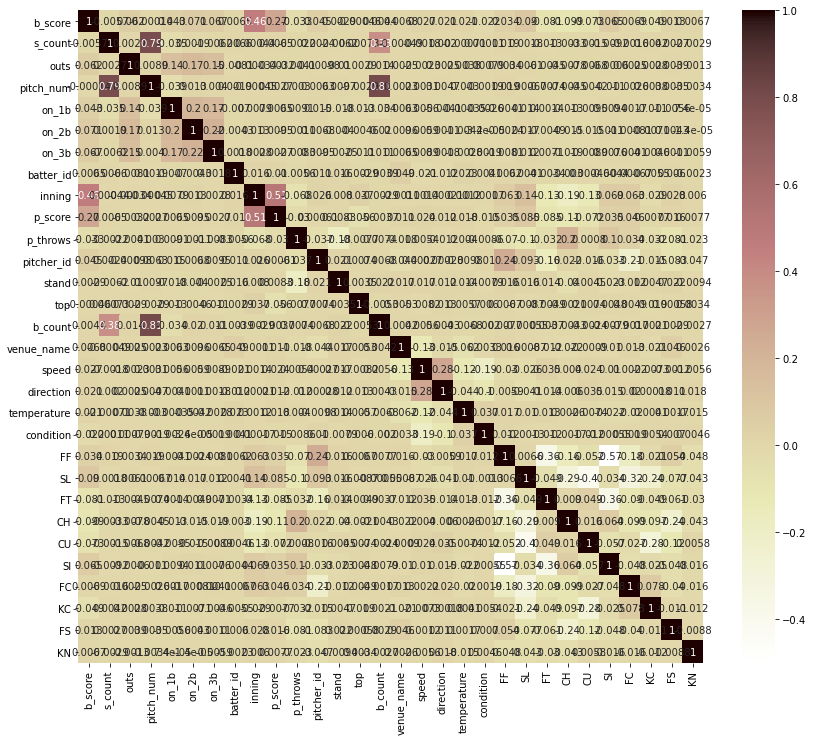

In [171]:
correlation = features.corr() 
plt.figure(figsize=(14,12)) 
heatmap = sns.heatmap(correlation, annot=True, linewidths = 0, vmin=-.5, cmap='pink_r')

In [172]:
# Drop pitch_num by looking at the correlation plots 
# pitch_num has strong correlation with b_count, s_count
features = features.drop('pitch_num', axis=1)

In [173]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610876 entries, 0 to 616267
Data columns (total 29 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   b_score      610876 non-null  float64
 1   s_count      610876 non-null  float64
 2   outs         610876 non-null  float64
 3   on_1b        610876 non-null  float64
 4   on_2b        610876 non-null  float64
 5   on_3b        610876 non-null  float64
 6   batter_id    610876 non-null  int64  
 7   inning       610876 non-null  int64  
 8   p_score      610876 non-null  int64  
 9   p_throws     610876 non-null  int64  
 10  pitcher_id   610876 non-null  int64  
 11  stand        610876 non-null  int64  
 12  top          610876 non-null  int64  
 13  b_count      610876 non-null  float64
 14  venue_name   610876 non-null  int64  
 15  speed        610876 non-null  int64  
 16  direction    610876 non-null  int64  
 17  temperature  610876 non-null  int64  
 18  condition    610876 non-

In [174]:
# y value = pitch_type
target = df['pitch_type']

In [175]:
example = features

In [176]:
target_e = target

In [130]:
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score
import xgboost as xgb
import random
from sklearn.model_selection import GridSearchCV

In [177]:
#splitting the train and test data for the XGB model
X_train, X_test, y_train, y_test = train_test_split(example, target_e, test_size=0.10, random_state = 77777)
#create xgb instance out of the box
clf = xgb.XGBClassifier(eval_metric='mlogloss')
#fit data
clf.fit(X_train, y_train)
#make predictions
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
#run classification report and confusion matrix
gbt_confusion_matrix = confusion_matrix(y_test, val_preds)
print(gbt_confusion_matrix)
gbt_classification_report = classification_report(y_test, val_preds)
print(gbt_classification_report)

/Users/bradyhong/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[[ 1067   163   215  3100     9   775    93     0   741   347]
 [  184   752   248  2562    14   521     0     3   413   327]
 [  167    93  1342  1029    21   306   117     0   259    83]
 [  586   450   469 15649   246  1006   188     2   364  2071]
 [    0     9     6   393   365    63     5     0    18    52]
 [  263   219   243  1795    23  3743    84     0     0   881]
 [   41     0    41   699    11   117   484     0   141    30]
 [    0     2     0     0     0     0     0    70     0     0]
 [  210   109   111   273    11     0    64     0  3767   343]
 [  154   126   159  4326    52  1106    25     0   852  3620]]
              precision    recall  f1-score   support

          CH       0.40      0.16      0.23      6510
          CU       0.39      0.15      0.22      5024
          FC       0.47      0.39      0.43      3417
          FF       0.52      0.74      0.62     21031
          FS       0.49      0.40      0.44       911
          FT       0.49      0.52      0.50 

In [111]:
# Doesn't work with n_jobs=-1. 
# 만약 계속 안되면 n_jobs=1로 해보셈
clf = xgb.XGBClassifier(eval_metric='mlogloss')
#clf.fit(X_train, y_train)
Xgb_train, Xgb_test, yxgb_train, yxgb_test = train_test_split(example, target_e, test_size=0.10, random_state = 77777)
xgb_param_grid = {"learning_rate": [0.1,1],'max_depth': [2,6],'min_child_weight': [5,10],'n_estimators': [50, 100]}
gs = GridSearchCV(clf, xgb_param_grid, n_jobs=1, cv=3)
gs.fit(Xgb_train, yxgb_train)

/Users/bradyhong/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


KeyboardInterrupt: 

In [ ]:
gs.best_params_

In [ ]:
# put the parameter inside XGBClassifier that u got from gs.best_param
X_train, X_test, y_train, y_test = train_test_split(example, target_e, test_size=0.10, random_state = 77777)
#create xgb instance with parameters
clf = xgb.XGBClassifier(learning_rate=1,max_depth=6,min_child_weight=10,n_estimators=50)
#fit data
clf.fit(X_train, y_train)
#make predictions
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
#run classification report and confusion matrix
gbt_confusion_matrix = confusion_matrix(y_test, val_preds)
print(gbt_confusion_matrix)
gbt_classification_report = classification_report(y_test, val_preds)
print(gbt_classification_report)

In [1]:
features.info()

NameError: name 'features' is not defined

In [367]:
# KNN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(example, target_e, test_size=0.10, random_state = 77777)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
test_error = []
# Calculating error for K values of 1,4,9,16,25,36,49,64,81,100
for i in range(1, 50):
    #print(i**2)
    print(i)
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    test_error.append(np.mean(pred_i != y_test))
a = min(test_error)
for i in range(0,len(test_error)):
    if test_error[i]==a:
        print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
10


Text(0, 0.5, 'Error Rate')

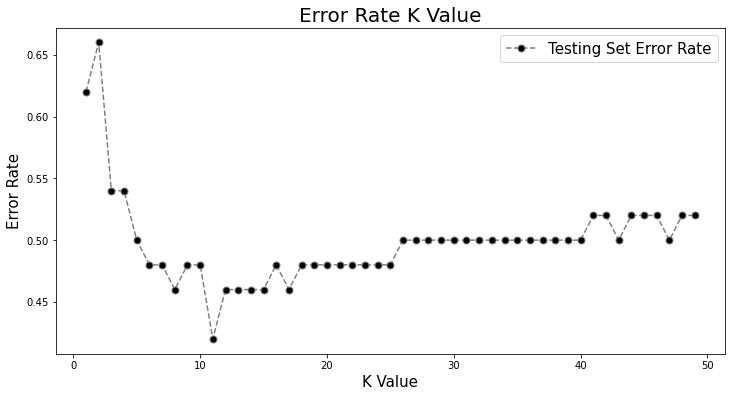

In [368]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 50), test_error, color='grey', linestyle='dashed', marker='o', 
         markerfacecolor='black', markersize=7, label='Testing Set Error Rate')
plt.legend(fontsize = 15)
plt.title('Error Rate K Value', fontsize = 20)
plt.xlabel('K Value', fontsize = 15)
plt.ylabel('Error Rate', fontsize = 15)

In [369]:
print(a)

0.42


In [370]:
# Put the number that you got from KNN to n_neighbors
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=11)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [371]:
y_pred = classifier.predict(X_test)

In [372]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred,zero_division=True))

[[ 3  0  0  3  0]
 [ 1  1  0  4  0]
 [ 0  0  0  1  0]
 [ 2  0  0 24  0]
 [ 0  2  0  8  1]]
              precision    recall  f1-score   support

          CH       0.50      0.50      0.50         6
          FC       0.33      0.17      0.22         6
          FF       1.00      0.00      0.00         1
          SI       0.60      0.92      0.73        26
          SL       1.00      0.09      0.17        11

    accuracy                           0.58        50
   macro avg       0.69      0.34      0.32        50
weighted avg       0.65      0.58      0.50        50



In [429]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [10000, 50]

In [263]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_test, y_test)

accuracy_score(y_train, model.predict(X_train))

0.3477777777777778